# Dpi Setting

In [106]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


In [109]:
import os

print(os.getcwd())

/home/divar/projects/graphical-sampling


In [110]:
import os
os.chdir('/home/divar/projects/graphical-sampling')

### Dependencies

### Python

In [111]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [112]:
!apt-get install -y r-base
#!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [113]:
from rpy2.robjects.packages import importr

import numpy as np
from rpy2.robjects import numpy2ri, default_converter, globalenv
from rpy2.robjects.conversion import localconverter

In [114]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [115]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

### Imports

In [116]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#numpy2ri.activate()

rng = gs.random.rng()

## Functions

### Scores in R

In [117]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    with localconverter(default_converter + numpy2ri.converter):
      globalenv['sample_mask'] = sample_mask
      globalenv['sample_idx'] = sample_idx + 1  # Or int(sample_idx + 1) if it's just one value
      globalenv['coords'] = coords
      globalenv['probs'] = probs
      globalenv['n'] = n
      globalenv['N'] = N
    # ro.globalenv['sample_mask'] = sample_mask
    # ro.globalenv['sample_idx'] = sample_idx + 1
    # ro.globalenv['coords'] = coords
    # ro.globalenv['probs'] = probs
    # ro.globalenv['n'] = n
    # ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SB_value = ro.r("sb_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], IB_value, SBLB_value
    # return scores[0][0], SB_value, IB_value, SBLB_value
    # Legacy Measure: return scores[3][0], SB_value, IB_value, SBLB_value

### Functions

In [118]:
autumn_cmap = plt.get_cmap('autumn')
plasma_cmap = plt.get_cmap('plasma')

def get_autumn_colors(n_clusters):
    """Returns n_clusters colors from the autumn colormap."""
    colors = autumn_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

def get_plasma_colors(n_clusters):
    """Returns n_clusters colors from the plasma colormap."""
    colors = plasma_cmap(np.linspace(0.15, 0.95, n_clusters))
    return colors

# Example usage:
n = 10  # Number of clusters
n_clusters = n
import matplotlib.pyplot as plt
import numpy as np

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(mc.to_rgb(c))
    white = np.array([1, 1, 1])
    return tuple((1 - amount) * c + amount * white)

n_clusters = n
base_colors = plt.cm.plasma(np.linspace(0, 1, n_clusters))
light_colors = [lighten_color(col, 0.5) for col in base_colors]

autumn_colors = get_autumn_colors(n_clusters)
plasma_colors = get_plasma_colors(n_clusters)
plasma_colors = light_colors

In [119]:
def plot_convex_hull(points, ax, color, alpha=0.33, edge_color="gray", line_width=0.6):
    """Plot convex hull safely. Always returns (ax, hull or None)."""
    if len(points) < 3:
        return ax, None
    try:
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
            zorder=1
        )
        ax.add_patch(polygon)
        return ax, hull
    except QhullError:
        # Can't make hull, skip
        return ax, None


# Simulations

### Methods

In [121]:
import numpy as np
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri

# Enable the numpy <-> R conversion
#rpy2.robjects.numpy2ri.activate()

def local_pivotal_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
s <- lpm(probs, coords) # Local Pivotal Method (BalancedSampling)
"""
        ro.r(r_code)
        sample_idx = np.array(list(ro.r("s"))) - 1
        samples_idx[i] = sample_idx

    return samples_idx

def k_means_samples(coords, probs, n, num_samples, n_zones):
    # Placeholder, replace with your actual method if necessary
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, tolerance=2, split_size=0.001).sample(num_samples)

def random_samples(coords, probs, n, num_samples):
    # Placeholder, replace with your own implementation if available
    return gs.sampling.RandomSampling(coords, probs, n=n).sample(num_samples)

def upmaxentropy_samples(probs, num_samples):
    ro.globalenv['probs'] = probs
    n = int(round(np.sum(probs)))

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
mask <- UPmaxentropy(probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx

def wave_samples(coords, probs, n, num_samples):
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs

    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = """
wave_mask <- wave(coords, probs)
"""
        ro.r(r_code)
        mask = np.array(ro.r("wave_mask"))
        if mask.dtype != np.bool_:
            mask = mask.astype(bool)
        sample_idx = np.where(mask)[0]
        samples_idx[i] = sample_idx

    return samples_idx



def spcosa_samples(coords, n, num_samples):
    """
    Uses the spcosa R package for equal probability spatially balanced sampling.
    """
    ro.globalenv['coords'] = coords
    N = coords.shape[0]
    samples_idx = np.zeros((num_samples, n), dtype=int)
    for i in range(num_samples):
        r_code = f"""
library(spcosa)
set.seed({np.random.randint(1, 1e8)})
df <- data.frame(x = coords[,1], y = coords[,2])
coordinates(df) <- ~x + y
gridded(df) <- TRUE
stratification <- stratify(df, nStrata = {n}, nTry = 50)
samples <- spsample(stratification)
# Extract row indices in original data
whichrow <- as.integer(rownames(as(samples, "data.frame")))
"""
        ro.r(r_code)
        sample_idx = np.array(ro.r("whichrow")) - 1  # zero-based for Python
        samples_idx[i] = sample_idx
    return samples_idx


def find_samples(coords, probs, n, num_samples, ep_mode="auto"):
    """
    Returns a dict of various sampling methods. 
    If ep_mode=="auto", heuristically deduce EP/UP from probs.
    """
    # Determine if this is the EP case: uniform probs and sum ~ n
    #is_EP = np.allclose(probs, probs[0]) and np.isclose(np.sum(probs), n)
    result = {
        # "K-Means (45_random_)": k_means_samples(coords, probs, n, num_samples, (4, 5)),
        # "K-Means (11_random_)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        "K-Means (22_sort_)": k_means_samples(coords, probs, n, num_samples, (2, 2)),
        "K-Means (11_sort_)": k_means_samples(coords, probs, n, num_samples, (1, 1)),
        # "Local Pivotal": local_pivotal_samples(coords, probs, n, num_samples),
        # "Random": random_samples(coords, probs, n, num_samples),
        # "UPmaxentropy": upmaxentropy_samples(probs, num_samples),
        # "Wave": wave_samples(coords, probs, n, num_samples),
        }
    # if is_EP or ep_mode=="EP":
    #     result["spcosa"] = spcosa_samples(coords, n, num_samples)
    return result

### Gathering Data

In [36]:
import pandas as pd
import os

results_folder = 'data_samples/results'
result_files = [
    "results_grid_eq.csv",
    "results_grid_uneq.csv",
    "results_random_eq.csv",
    "results_random_uneq.csv",
    "results_clust_eq.csv",
    "results_clust_uneq.csv",
]

methods_to_remove = ["K-Means (45_random_)", "K-Means (11_random_)"]

for filename in result_files:
    filepath = os.path.join(results_folder, filename)
    df = pd.read_csv(filepath)
    # Remove rows where the 'Method' column matches the unwanted method
    df_filtered = df[~df['Method'].isin(methods_to_remove)]

    # Save back (overwrite the original file; change filename if you want a backup)
    df_filtered.to_csv(filepath, index=False)
    print(f"Filtered {filename}: {len(df) - len(df_filtered)} rows removed.")

Filtered results_grid_eq.csv: 2000 rows removed.
Filtered results_grid_uneq.csv: 2000 rows removed.
Filtered results_random_eq.csv: 2000 rows removed.
Filtered results_random_uneq.csv: 2000 rows removed.
Filtered results_clust_eq.csv: 2000 rows removed.
Filtered results_clust_uneq.csv: 2000 rows removed.


In [122]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
    "grid_eq", "grid_uneq",
    "clust_eq", "clust_uneq",
    "random_eq", "random_uneq"
]
# names = [
#     "swiss_uneq",
#     ]
#names = ["random_uneq"]
for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)
print(sum(probs))
print(len(probs))
sample_cnt = 1000
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]
columns = ["Method", "Density", "Moran", "Local Balance"]

for coords, probs, name in zip(all_coords, all_probs, names):
    print('name:', name)
    n = int(np.round(np.sum(probs)))
    N =len(probs)
    # Any code for one set, put here:
    sample_methods = find_samples(coords, probs, n, sample_cnt)
    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    print('density_measure:', density_measure)
    rows = np.array([
    [method, *scores(coords, probs, n, N, s, density_measure)]
    for method, samples in sample_methods.items()
    if samples is not None  # <----- add this
    for s in tqdm(samples, total=sample_cnt)
])
    df = pd.DataFrame(rows, columns=columns)
    df = df.astype({
        "Density": float,
        #"Voronoi": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"initial_results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

3.9999999999999782
400
name: grid_eq
density_measure: <geometric_sampling.measure.density.Density object at 0x71beef349f40>


100%|██████████| 1000/1000 [33:29<00:00,  2.01s/it]


Saved: data_samples/results/initial_results_grid_eq.csv
name: grid_uneq
density_measure: <geometric_sampling.measure.density.Density object at 0x71bebf379940>


100%|██████████| 1000/1000 [49:14<00:00,  2.95s/it]


Saved: data_samples/results/initial_results_grid_uneq.csv
name: clust_eq
density_measure: <geometric_sampling.measure.density.Density object at 0x71bebd9a67e0>


100%|██████████| 1000/1000 [36:23<00:00,  2.18s/it]


Saved: data_samples/results/initial_results_clust_eq.csv
name: clust_uneq
density_measure: <geometric_sampling.measure.density.Density object at 0x71bee4e467e0>


100%|██████████| 1000/1000 [33:46<00:00,  2.03s/it]


Saved: data_samples/results/initial_results_clust_uneq.csv
name: random_eq
density_measure: <geometric_sampling.measure.density.Density object at 0x71beef329af0>


100%|██████████| 1000/1000 [21:45<00:00,  1.31s/it]


Saved: data_samples/results/initial_results_random_eq.csv
name: random_uneq
density_measure: <geometric_sampling.measure.density.Density object at 0x71beef280590>


100%|██████████| 1000/1000 [29:57<00:00,  1.80s/it]

Saved: data_samples/results/initial_results_random_uneq.csv


3.9999999999999587
400


  0%|          | 0/5 [00:00<?, ?it/s]

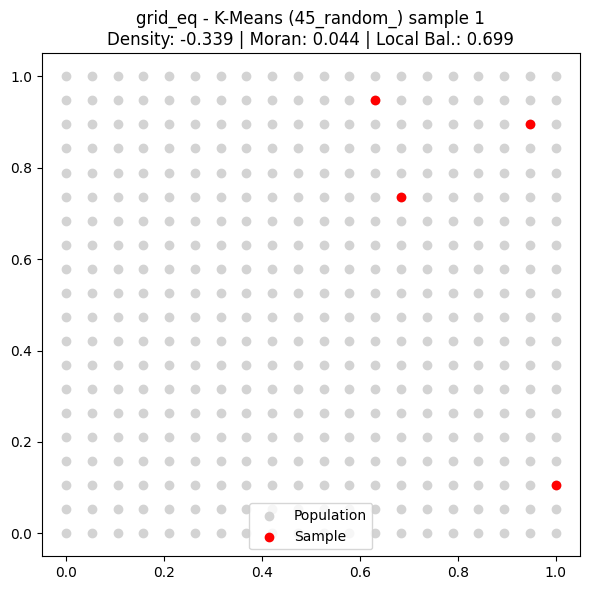

 20%|██        | 1/5 [00:01<00:07,  1.92s/it]

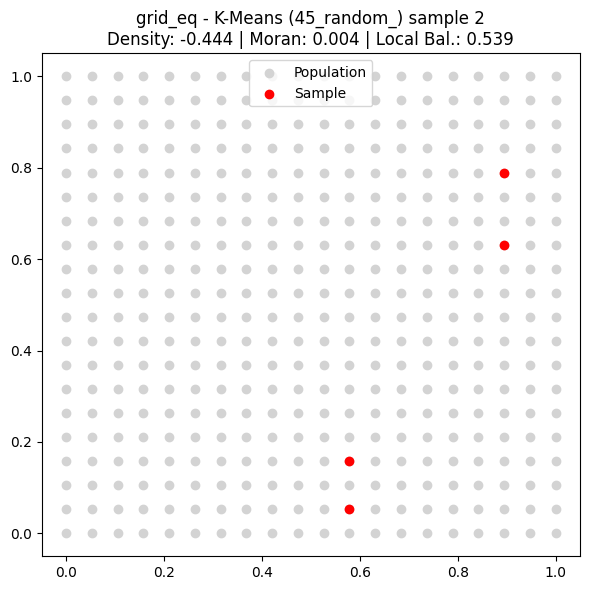

 40%|████      | 2/5 [00:03<00:04,  1.53s/it]

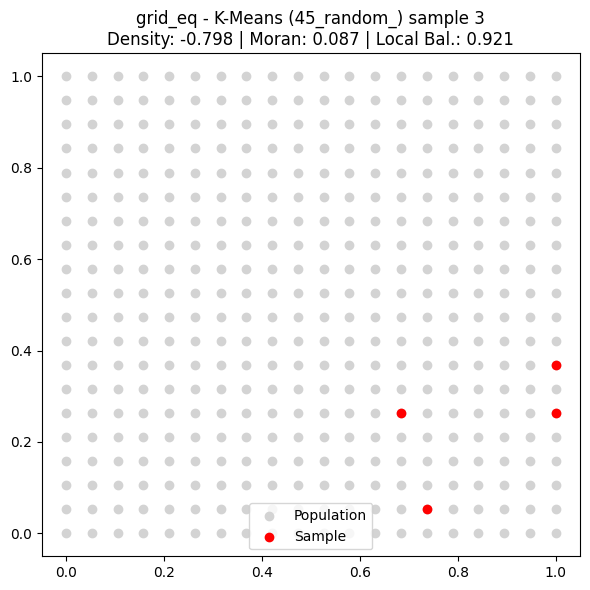

 60%|██████    | 3/5 [00:04<00:02,  1.48s/it]

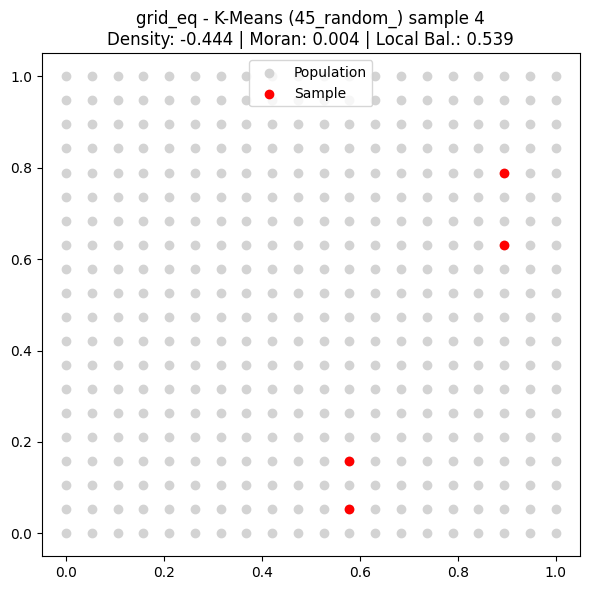

 80%|████████  | 4/5 [00:05<00:01,  1.44s/it]

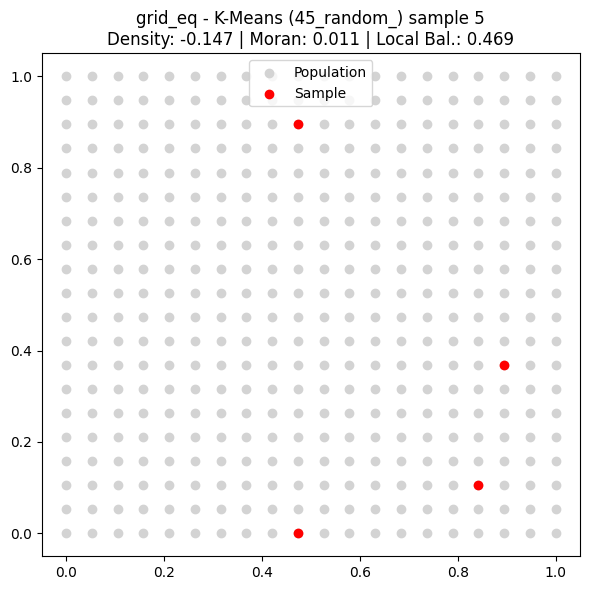

100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


Saved: data_samples/results/initial_results_grid_eq.csv


  0%|          | 0/5 [00:00<?, ?it/s]

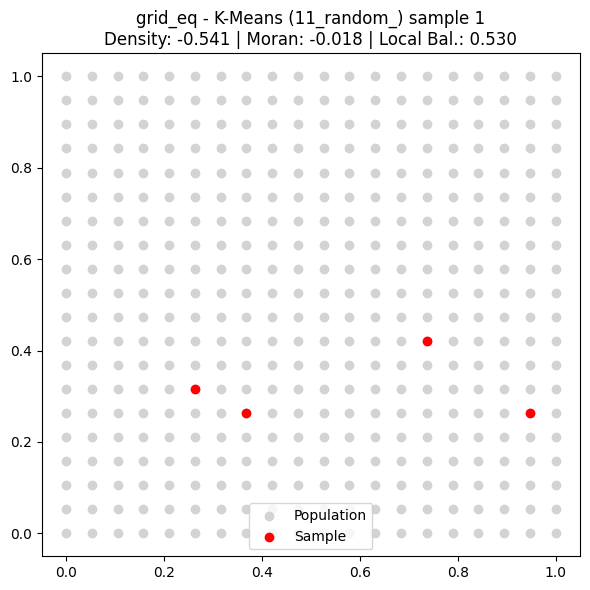

 20%|██        | 1/5 [00:01<00:05,  1.43s/it]

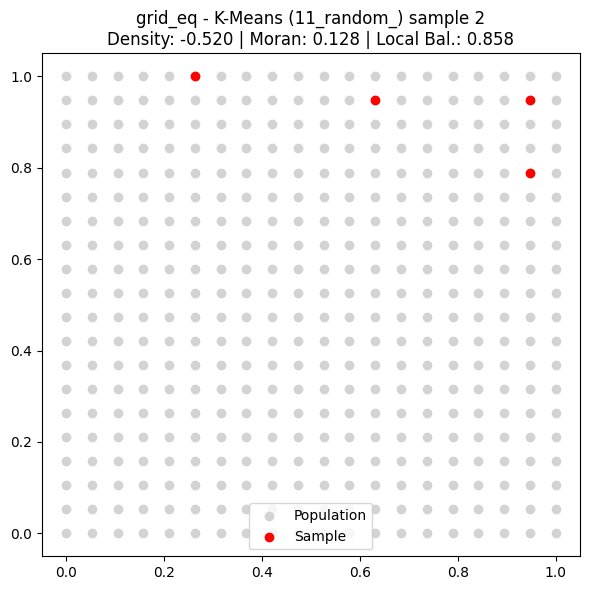

 40%|████      | 2/5 [00:03<00:05,  1.75s/it]

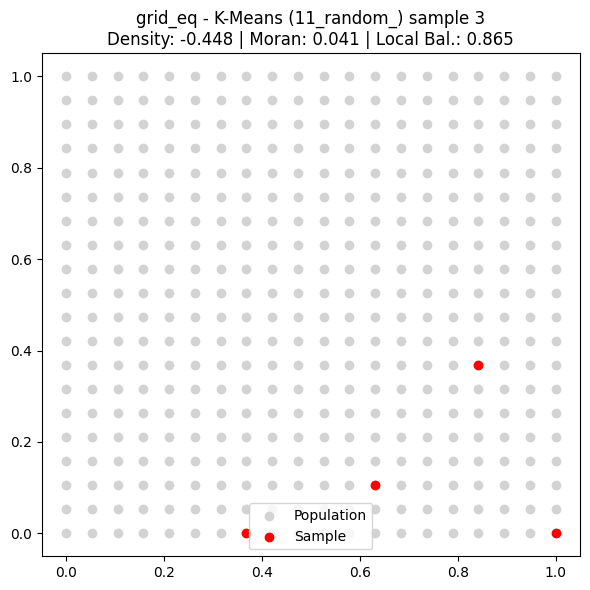

 60%|██████    | 3/5 [00:04<00:03,  1.53s/it]

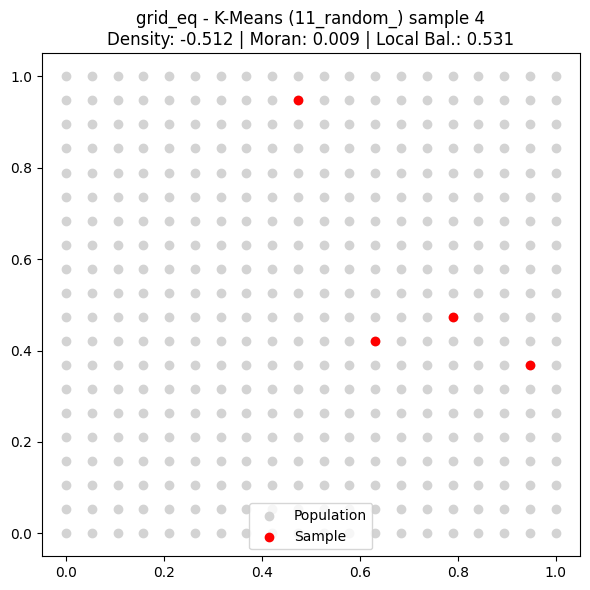

 80%|████████  | 4/5 [00:06<00:01,  1.49s/it]

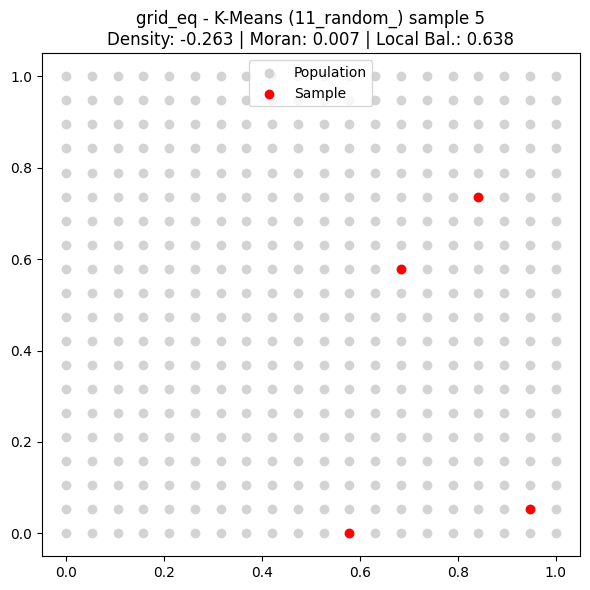

100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

Saved: data_samples/results/initial_results_grid_eq.csv


In [67]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
folder = "data_samples/results"
os.makedirs(folder, exist_ok=True)
all_coords = []
all_probs = []
names = [
     "grid_eq"
]
# names = [
#     "swiss_uneq",
#     ]
#names = ["random_uneq"]
for name in names:
    df = pd.read_csv(f"data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)
print(sum(probs))
print(len(probs))
sample_cnt = 5
columns = ["Method", "Density", "Voronoi", "Moran", "Local Balance"]
columns = ["Method", "Density", "Moran", "Local Balance"]

import matplotlib.pyplot as plt

rows = []
for method, samples in sample_methods.items():
    if samples is None:
        continue
    for idx, s in enumerate(tqdm(samples, total=sample_cnt)):
        density, moran, local_balance = scores(coords, probs, n, N, s, density_measure)
        
        plt.figure(figsize=(6, 6))
        plt.scatter(coords[:,0], coords[:,1], c='lightgray', marker='o', label='Population')
        plt.scatter(coords[s,0], coords[s,1], c='red', marker='o', label='Sample')
        plt.title(
            f"{name} - {method} sample {idx+1}\n"
            f"Density: {density:.3f} | Moran: {moran:.3f} | Local Bal.: {local_balance:.3f}"
        )
        plt.legend()
        plt.tight_layout()
        plt.show()  # Or savefig as mentioned above

        rows.append([method, density, moran, local_balance])

    df = pd.DataFrame(rows, columns=columns)
# ... rest of your code
    df = df.astype({
        "Density": float,
        #"Voronoi": float,
        "Moran": float,
        "Local Balance": float
    })
    filename = os.path.join(folder, f"initial_results_{name}.csv")
    df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

In [123]:
import os
import pandas as pd

folder = "data_samples/results"
names = [
    "clust_eq", "clust_uneq",
    "grid_eq", "grid_uneq",
    "random_eq", "random_uneq"
]

for name in names:
    # File paths
    initial_result_path = os.path.join(folder, f"initial_results_{name}.csv")
    result_path = os.path.join(folder, f"results_{name}.csv")

    # Read initial results (with header)
    initial_df = pd.read_csv(initial_result_path)

    # Read simulation results (SKIP header, but use correct columns)
    result_df = pd.read_csv(result_path, skiprows=1, names=initial_df.columns)

    # Combine both, initial first, then simulation
    combined_df = pd.concat([initial_df, result_df], ignore_index=True)

    # Overwrite results file (no header duplication!)
    combined_df.to_csv(result_path, index=False)
    print(f"Overwritten: {result_path}")

Overwritten: data_samples/results/results_clust_eq.csv
Overwritten: data_samples/results/results_clust_uneq.csv
Overwritten: data_samples/results/results_grid_eq.csv
Overwritten: data_samples/results/results_grid_uneq.csv
Overwritten: data_samples/results/results_random_eq.csv
Overwritten: data_samples/results/results_random_uneq.csv


## Results

##### Three Population

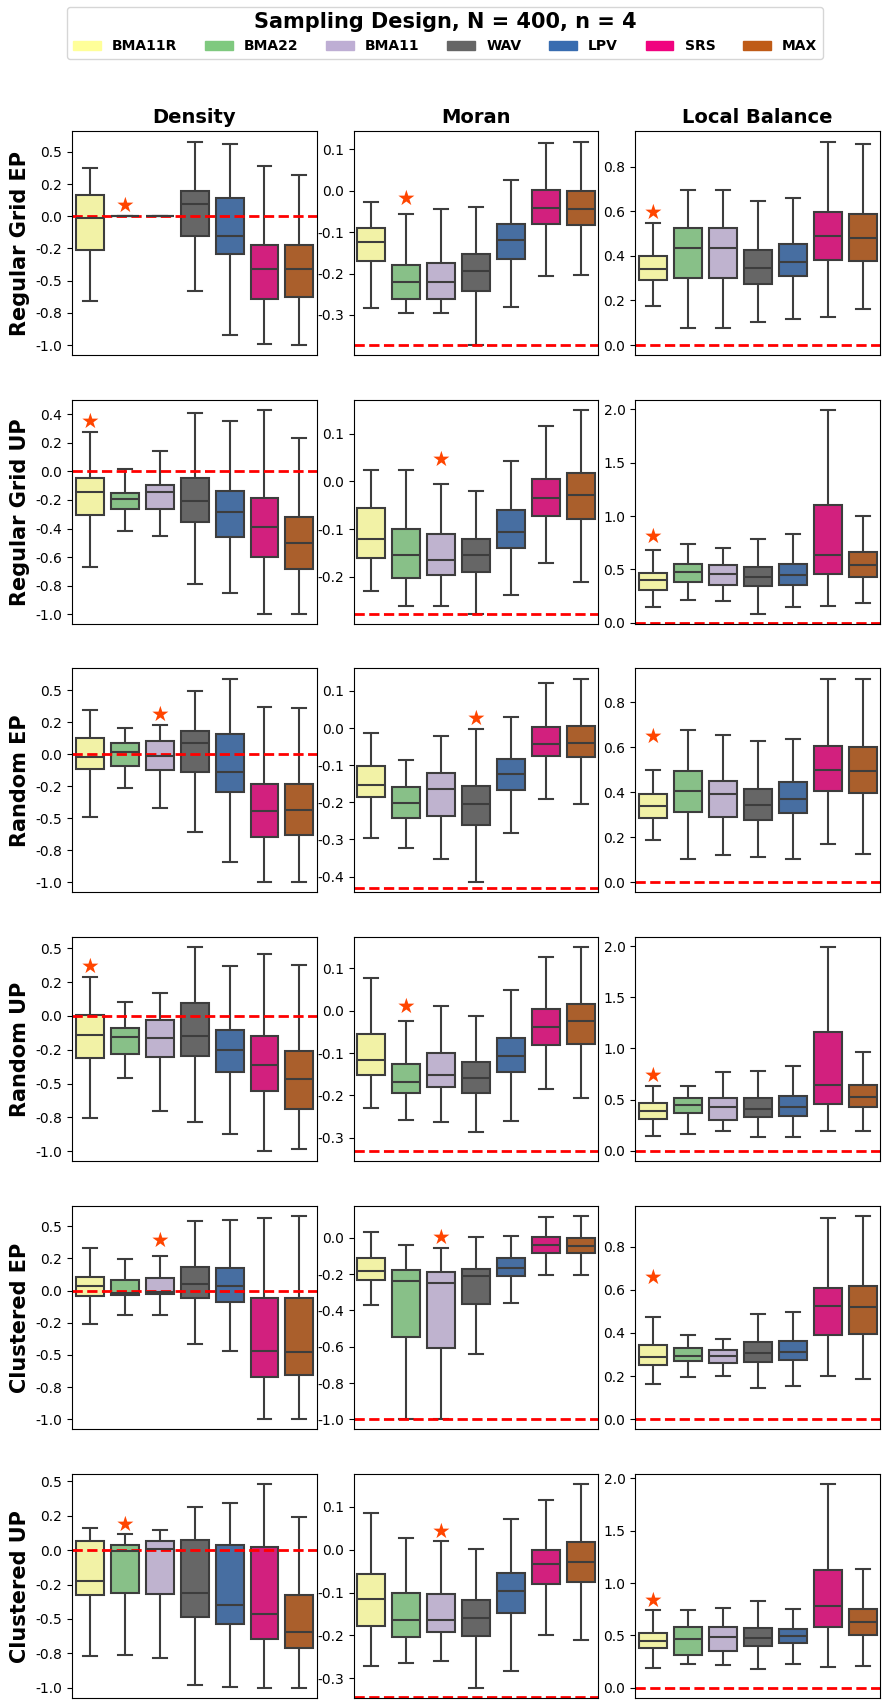

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

# Folder and file info
method_order = ["BMA11R",'BMA22', 'BMA11', "WAV", "LPV",  "SRS", "MAX"]
results_folder = 'data_samples/results'
result_files = [
    "results_grid_eq.csv",
    "results_grid_uneq.csv",
    "results_random_eq.csv",
    "results_random_uneq.csv",
    "results_clust_eq.csv",
    "results_clust_uneq.csv",
]
pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}
pop_names = [s.replace("results_", "").replace(".csv", "") for s in result_files]

# Read results into a dict
colnames = ["Method", "Density", "Moran", "Voronoi"]
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname))
    results_dict[name] = df

# Mapping for nicer method names
method_name_mapping = {
    "K-Means (11_random_)": "BMA11R",
    "K-Means (22_sort_)": "BMA22",
    "K-Means (11_sort_)": "BMA11",
    "wave": "WAV",
    "Local Pivotal": "LPV",
    "Random": "SRS",
    "UPmaxentropy": "MAX"
}
for df in results_dict.values():
    df["Method"] = df["Method"].map(method_name_mapping)
for df in results_dict.values():
    if "Method Pretty" in df.columns:
        df.drop(columns=["Method Pretty"], inplace=True)
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel1", n_colors=len(all_methods))))
method_palette = dict(zip(all_methods, sns.color_palette("Spectral", n_colors=len(all_methods))))
method_palette = dict(zip(all_methods, sns.color_palette("husl", n_colors=len(all_methods))))
method_palette = dict(zip(all_methods, sns.color_palette("Accent", n_colors=len(all_methods))))
# method_palette = dict(zip(all_methods, sns.color_palette("Paired", n_colors=len(all_methods))))
# method_palette = dict(zip(all_methods, sns.color_palette("nipy_spectral", n_colors=len(all_methods))))

columns = [c for c in results_dict[pop_names[0]].columns if c != "Method"]

# ---------- Annotate Closest Median -----------
def find_closest_method(df, metric, dashed_line_value):
    # method -> median
    medians = df.groupby('Method')[metric].median()
    closest_method = (medians - dashed_line_value).abs().idxmin()
    closest_median = medians[closest_method]
    return closest_method, closest_median

# Create 6x4 grid (6 populations, 4 metrics)
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric] < 2],
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
        )
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
        ax.tick_params(axis='x', length=0)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))  # 2 decimals

        # Draw dashed line:
        if metric in ['Density', 'Voronoi', 'Local Balance']:
            dashed_line_value = 0
            ax.axhline(y=dashed_line_value, color='red', linestyle='--', linewidth=2)
        else:
            dashed_line_value = df_pop['Moran'].min()
            ax.axhline(y=dashed_line_value, color='red', linestyle='--', linewidth=2)

        # --------- Add annotation for closest median ----------
        # --------- Add annotation for closest median (at boxplot max) ----------
        method, method_median = find_closest_method(df_pop, metric, dashed_line_value)
        if method in method_order:
            x_pos = method_order.index(method)
            # Find the maximum value for this method's data (of filtered data)
            filtered = df_pop[df_pop[metric] < 2]  # Same filter as you use in the plot
            method_data = filtered[filtered["Method"] == method][metric].dropna()
            if len(method_data) > 0:
                box_max = method_data.max()
                box_min = method_data.min()
                ylim = ax.get_ylim()
                # Set star a bit above the boxplot whisker (5% of y-span)
                y_offset = 0.08 * (ylim[1] - ylim[0])
                star_y = box_max + y_offset
                star_y = box_max
                name_y = box_min - y_offset
                ax.annotate("★", (x_pos, star_y), ha="center", va="bottom",
            fontsize=15, color="orangered", fontweight="bold")
                #🔥 ★
                # ax.annotate(f"{method}", (x_pos, star_y), ha="center", fontsize=9)
                #ax.annotate(f"{method}", (x_pos+1, star_y), ha="center", color='darkblue' ,fontsize=5, fontweight="bold")

        
            
           
# ----------- SHARED LEGEND BLOCK -----------
fig_legend, ax_legend = plt.subplots()
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)
sns.boxplot(
    x="Method",
    y=columns[0],
    data=df_concat,
    palette=method_palette,
    ax=ax_legend,
    showfliers=False
)
from matplotlib.patches import Patch
labels = method_order
handles = [Patch(color=method_palette[l]) for l in labels]
plt.close(fig_legend)
leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(all_methods),
    title="Sampling Design, N = 400, n = 4",
    fontsize=10,
    title_fontsize=15
)

for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.2)

plt.show()
